In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import fsspec

from ufs2arco import Layers2Pressure

### Open GRIB2 file from Replay, random date

In [2]:
uri = "filecache::s3://noaa-ufs-gefsv13replay-pds/1deg/1996/01/1996010106/GFSPRS.GrbF00"
file = fsspec.open_local(uri, s3={"anon": True}, filecache={"cache_storage": "~/gribcache"})

In [3]:
grds = xr.open_dataset(
    file,
    engine="cfgrib",
#    filter_by_keys={'typeOfLevel': 'meanSea'}
#    filter_by_keys={'typeOfLevel': 'hybrid'}
#    filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
#    filter_by_keys={'typeOfLevel': 'surface'}
#    filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
#    filter_by_keys={'typeOfLevel': 'isobaricInPa'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
#    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
#    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
#    filter_by_keys={'typeOfLevel': 'heightAboveSea'}
#    filter_by_keys={'typeOfLevel': 'lowCloudLayer'}
#    filter_by_keys={'typeOfLevel': 'middleCloudLayer'}
#    filter_by_keys={'typeOfLevel': 'highCloudLayer'}
#    filter_by_keys={'typeOfLevel': 'cloudCeiling'}
#    filter_by_keys={'typeOfLevel': 'nominalTop'}
#    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
#    filter_by_keys={'typeOfLevel': 'tropopause'}
#    filter_by_keys={'typeOfLevel': 'maxWind'}
#    filter_by_keys={'typeOfLevel': 'isothermZero'}
#    filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
#    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
#    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
#    filter_by_keys={'typeOfLevel': 'sigma'}
#    filter_by_keys={'typeOfLevel': 'theta'}
#    filter_by_keys={'typeOfLevel': 'potentialVorticity'}
)
grds = grds.rename({"isobaricInhPa": "level"})
#grds = grds.isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4))

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,
        550.,  525.,  500.,  475.,  450.,  425.,  400.,  375.,  350.,
        325.,  300.,  275.,  250.,  225.,  200.,  175.,  150.,  125.,
        100.,   70.,   50.,   40.,   30.,   20.,   15.,   10.,    7.,
          5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobari

### Pull same data from our zarr store on GCS

In [4]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/1.00-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

rds = rds[["tmp", "pressfc", "delz", "dpres", "spfh", "ugrd", "vgrd", "dzdt"]]
rds = rds.sel(time=grds.time.values).load()
rds = rds.rename({"pfull": "level", "grid_xt": "longitude", "grid_yt": "latitude"})

### Compute Layer Mean Pressure

... among other things

In [5]:
lp = Layers2Pressure()

In [6]:
#delz = lp.calc_delz(rds["pressfc"], rds["tmp"], rds["spfh"])
delz = rds["delz"]

In [7]:
prsl = lp.calc_layer_mean_pressure(rds["pressfc"], rds["tmp"], rds["spfh"], delz)

In [16]:
pstar = 500 # hPa
pstar *= 100 # Pa
cds = lp._get_interp_coefficients(pstar, prsl)

In [17]:
maskR = (cds["is_right"].sum("level") > 0)
maskL = (cds["is_left"].sum("level") > 0)
mask = maskR & maskL

In [18]:
print("left")
print("maskL.all ", maskL.all().values)
print("mask == maskL ", (mask == maskL).all().values)
print()
print("right")
print("maskR.all ", maskR.all().values)
print("mask == maskR ", (mask == maskR).all().values)

left
maskL.all  True
mask == maskL  True

right
maskR.all  True
mask == maskR  True


In [19]:
kw = {"pstar": pstar, "prsl": prsl, "cds": cds}

In [20]:
valstar = {}
for key in ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]:
    valstar[key] = lp.interp2pressure(rds[key], **kw)

In [21]:
replay2grib = {
    "tmp": "t",
    "spfh": "q",
    "ugrd": "u",
    "vgrd": "v",
    "dzdt": "wz",
}

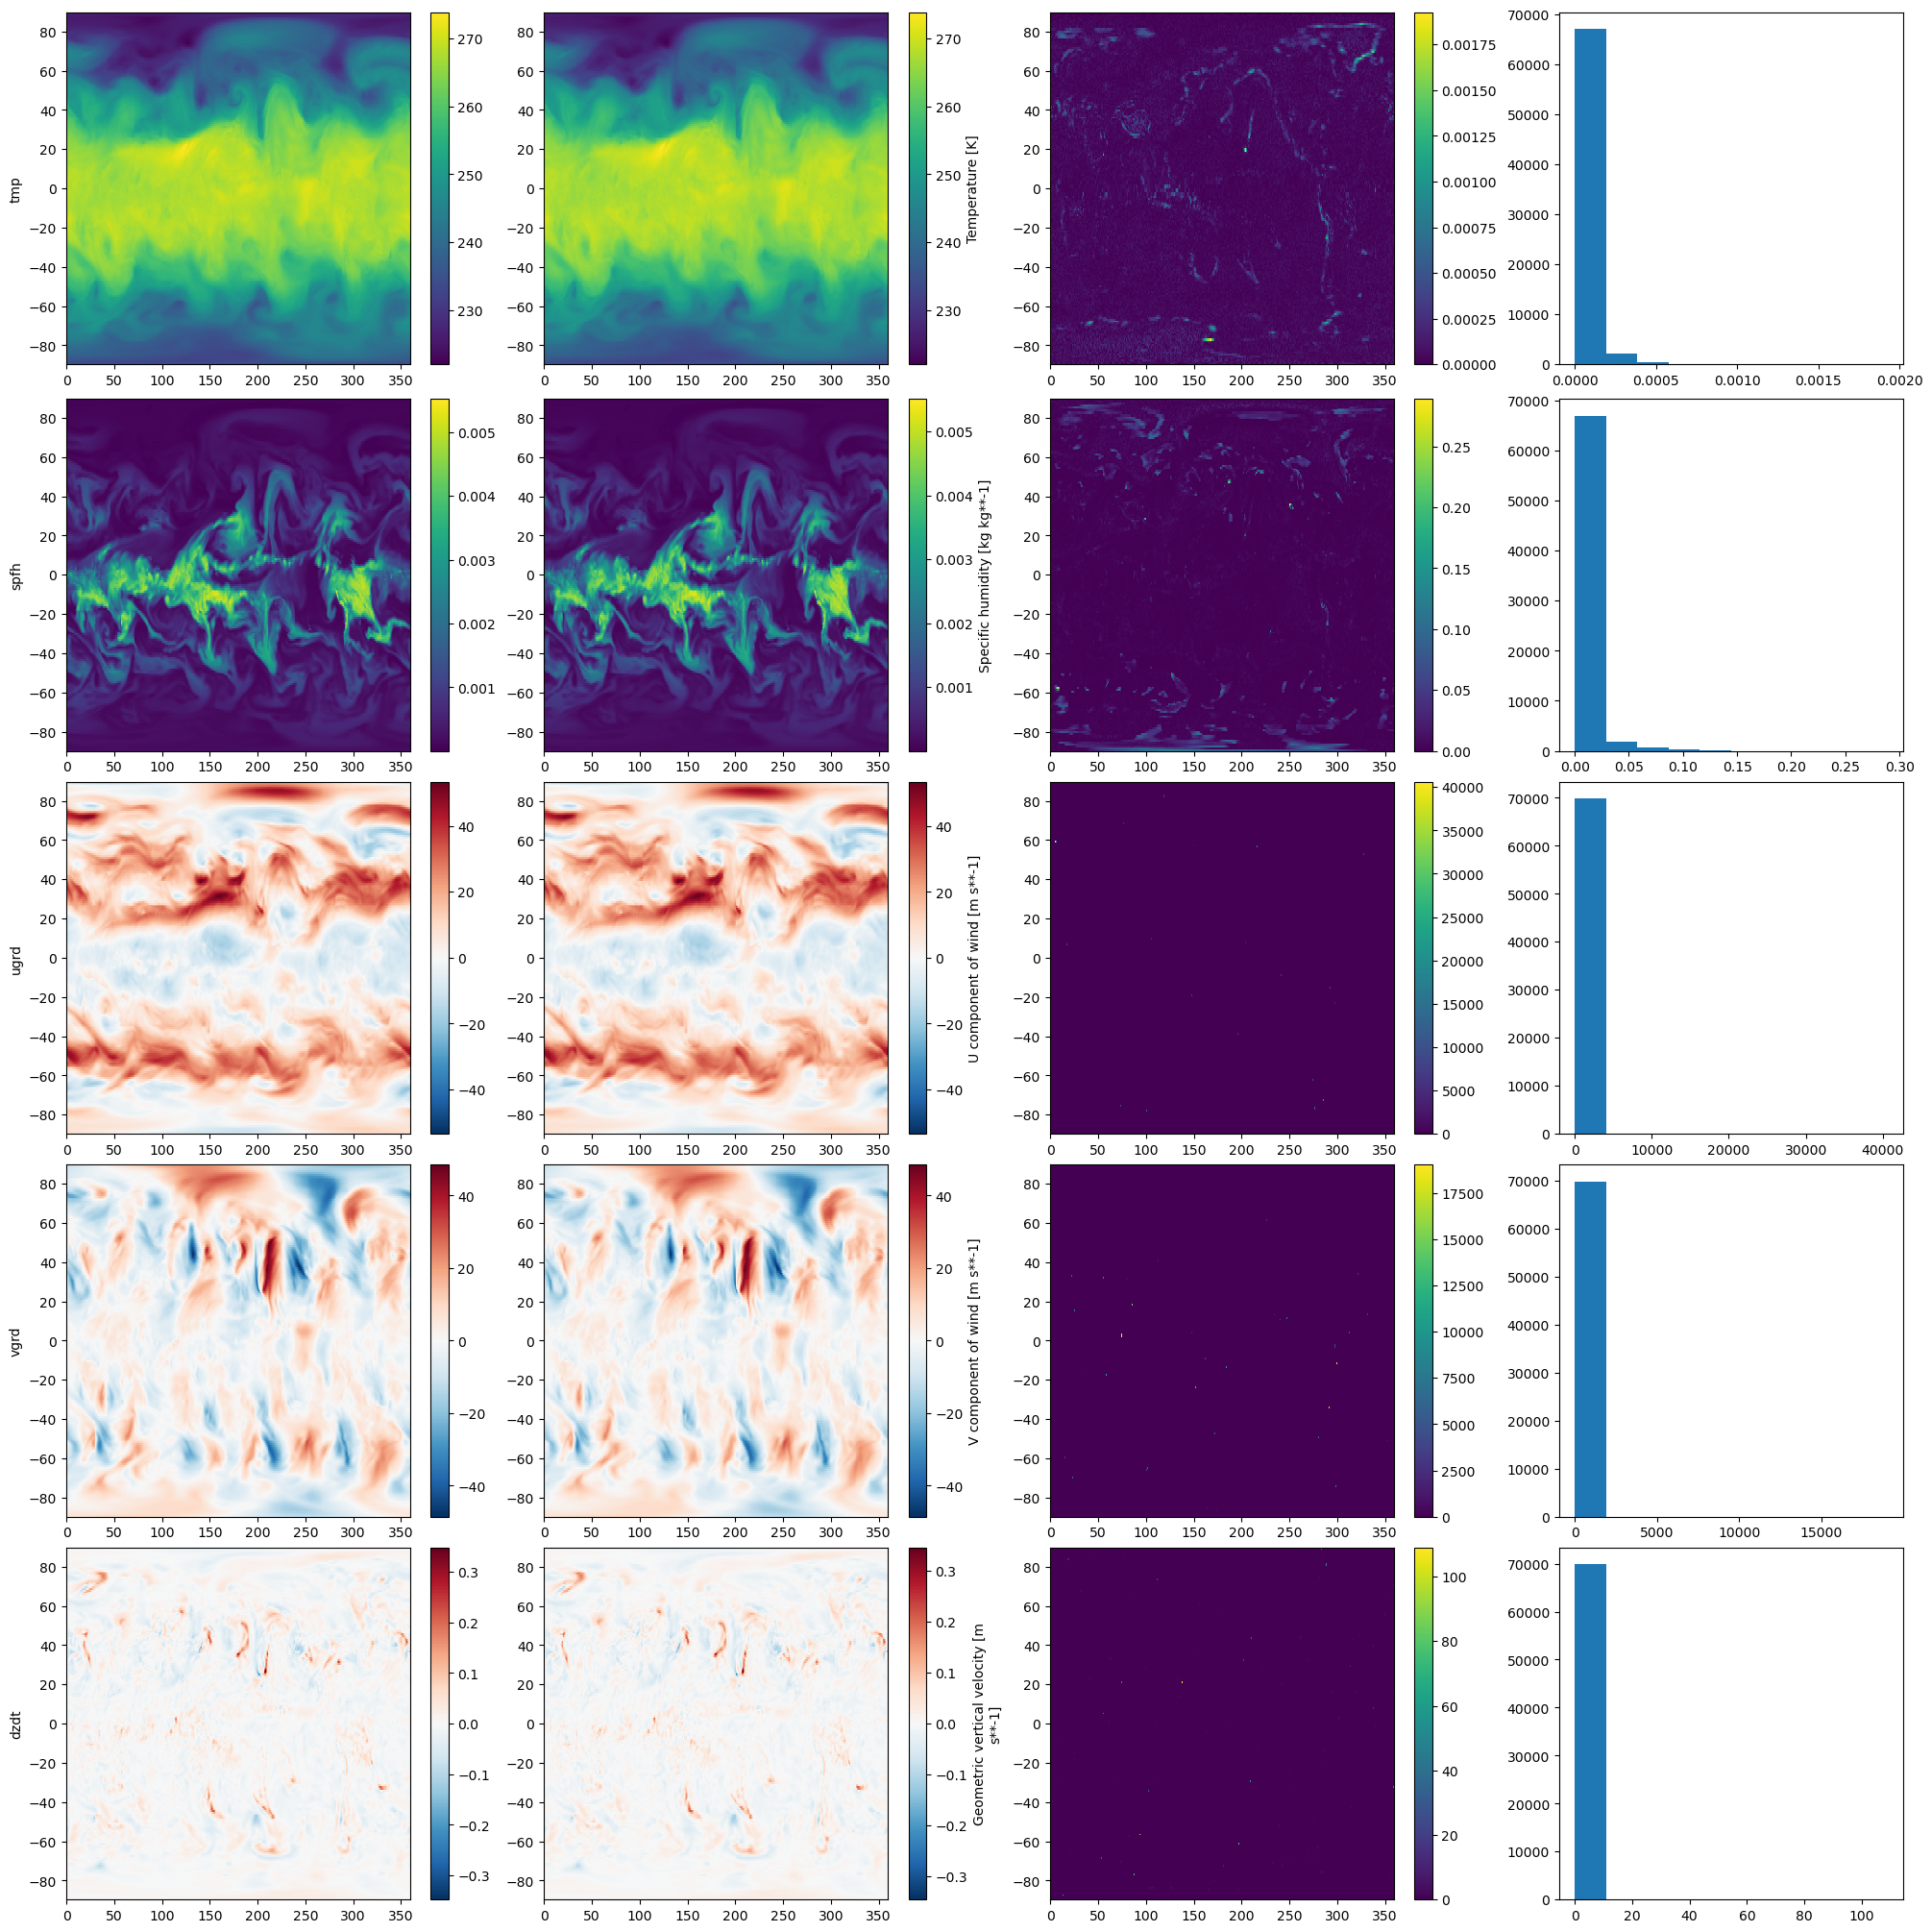

In [22]:
nrows = len(valstar)
fig, axs = plt.subplots(nrows, 4, figsize=(20, 4*nrows), constrained_layout=True)

for (key, xda), axr in zip(valstar.items(), axs):

    gxda = grds[replay2grib[key]].sel(level=pstar/100)#.where(mask)
    gxda = gxda.where(np.abs(gxda)>1e-6, 1e-6)
    diff = xda.where(mask) - gxda
    reldiff = np.abs(diff) / np.abs(gxda)

    xda.where(mask).plot(ax=axr[0])
    gxda.plot(ax=axr[1])
    reldiff.plot(ax=axr[2])
    reldiff.plot.hist(ax=axr[3])
    [ax.set(xlabel="", ylabel="", title="") for ax in axr]
    axr[0].set(ylabel=key)
    